In [64]:
import numpy as np

In [65]:
from HomoTopiContinuation.DataStructures.datastructures import Conic, Conics, Circle, Homography
from HomoTopiContinuation.SceneGenerator.scene_generator import SceneDescription, SceneGenerator

from HomoTopiContinuation.Rectifier.homotopyc_rectifier import HomotopyContinuationRectifier
from HomoTopiContinuation.ConicWarper.ConicWarper import ConicWarper

from HomoTopiContinuation.Losser.CircleLosser  import CircleLosser
from HomoTopiContinuation.Plotter.Plotter import Plotter


In [66]:
def sceneDefinition() -> SceneDescription:
    # Parameters
    f = 2
    theta = 30

    # Define the circles
    c1 = Circle(
        np.array([4, 4]), 1)
    c2 = Circle(
        np.array([3, 1]), 1)
    c3 = Circle(
        np.array([5, 1]), 1)

    print("Circle 1:")
    print(c1.to_conic().M)
    print([float(p) for p in c1.to_conic().to_algebraic_form()])
    print("Circle 2:")
    print(c2.to_conic().M)
    print([float(p) for p in c2.to_conic().to_algebraic_form()])
    print("Circle 3:")
    print(c3.to_conic().M)
    print([float(p) for p in c3.to_conic().to_algebraic_form()])

    offset = np.array([0, 0, 2])
    noiseScale = 0

    return SceneDescription(f, theta, offset, c1, c2, c3, noiseScale)

In [67]:
sceneDescription = sceneDefinition()

img = SceneGenerator().generate_scene(sceneDescription, debug=True)

H = img.h_true

Circle 1:
[[ 1  0 -4]
 [ 0  1 -4]
 [-4 -4 31]]
[1.0, 0.0, 1.0, -8.0, -8.0, 31.0]
Circle 2:
[[ 1  0 -3]
 [ 0  1 -1]
 [-3 -1  9]]
[1.0, 0.0, 1.0, -6.0, -2.0, 9.0]
Circle 3:
[[ 1  0 -5]
 [ 0  1 -1]
 [-5 -1 25]]
[1.0, 0.0, 1.0, -10.0, -2.0, 25.0]
No distortion params provided, using true conics


In [68]:
# compute the images of the circular points
I = np.array([1,1j,0])
J = np.array([1,-1j,0])

I_img = H.H @ I
J_img = H.H @ J

I_img = I_img / I_img[0]
J_img = J_img / J_img[0]

print(I_img)
print(J_img)


[1.        +0.j         1.03298823+0.04131953j 0.00998403+0.00039936j]
[1.        -0.j         1.03298823-0.04131953j 0.00998403-0.00039936j]


In [69]:
def perturb_circular_points(I_img, J_img, noise_scale):
    # Perturb the circular points
    I_img_perturbed = I_img + (np.random.normal(0, noise_scale, I_img.shape) + 1j*np.random.normal(0, noise_scale, I_img.shape))
    J_img_perturbed = J_img + (np.random.normal(0, noise_scale, J_img.shape) + 1j*np.random.normal(0, noise_scale, J_img.shape))
    return I_img_perturbed, J_img_perturbed



In [70]:
import tqdm

THRESHOLD = 1e-6      

rectifier = HomotopyContinuationRectifier()
losser = CircleLosser

N_ITER = 100
N_PERTURBATION_STEPS = 100
losses = np.zeros(N_ITER * N_PERTURBATION_STEPS)
#perturbation_steps = np.linspace(1e-6, 1e-3, N_PERTURBATION_STEPS)
# logartimic scale
perturbation_steps = np.logspace(-6, -3, N_PERTURBATION_STEPS)
perturbation_labels = np.zeros(N_PERTURBATION_STEPS * N_ITER)


for i, perturbation_scale in tqdm.tqdm(enumerate(perturbation_steps)):
    for j in range(N_ITER):
        # get perturbed points
        I_img_perturbed, J_img_perturbed = perturb_circular_points(I_img, J_img, perturbation_scale)
        # Apply SVD reconstruction starting from the perturbed points

        imDCCP = rectifier.compute_imDCCP_from_solutions(sols=np.array([I_img_perturbed, J_img_perturbed]))
        H_inv_computed = rectifier._compute_h_from_svd(imDCCP=imDCCP)
        # project the circles back
        warpedConics = ConicWarper().warpConics(img.C_img, H_inv_computed)
        loss = losser.computeCircleLoss(sceneDescription, warpedConics)
        #if (np.imag(np.max(loss)) < 1e-6):
        losses[i * N_ITER + j] = np.max(loss)
        perturbation_labels[i * N_ITER + j] = perturbation_scale
        


0it [00:00, ?it/s]/tmp/ipykernel_51416/2909650297.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  losses[i * N_ITER + j] = np.max(loss)
100it [00:31,  3.18it/s]


In [71]:
print(np.argmax(losses))
print(perturbation_labels[np.argmax(losses)])
print(losses[np.argmax(losses)])

x = 1

more_than_x = np.sum(losses >= x)
print(more_than_x)
print(losses.shape)

losses_clean = np.zeros(losses.shape)
losses_clean[losses >= x] = 1

# plot the distribution results

9846
0.0009326033468832199
280.9518950598575
1588
(10000,)


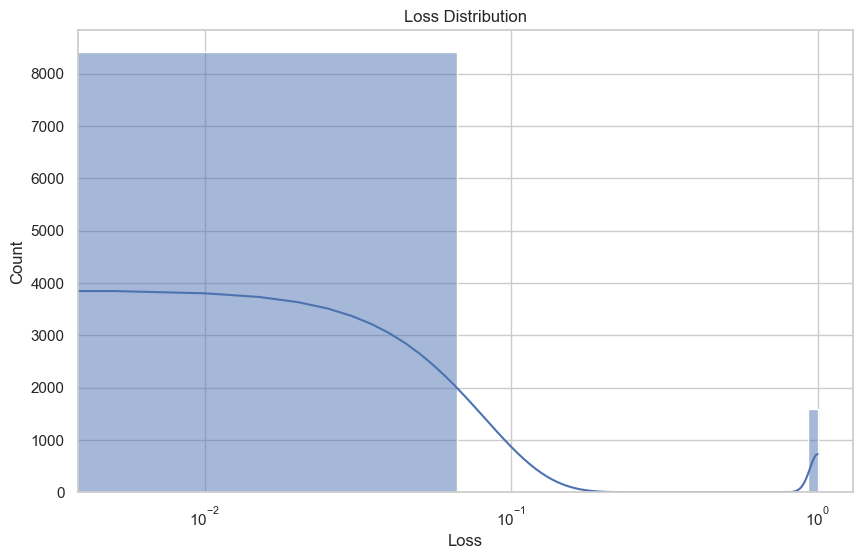

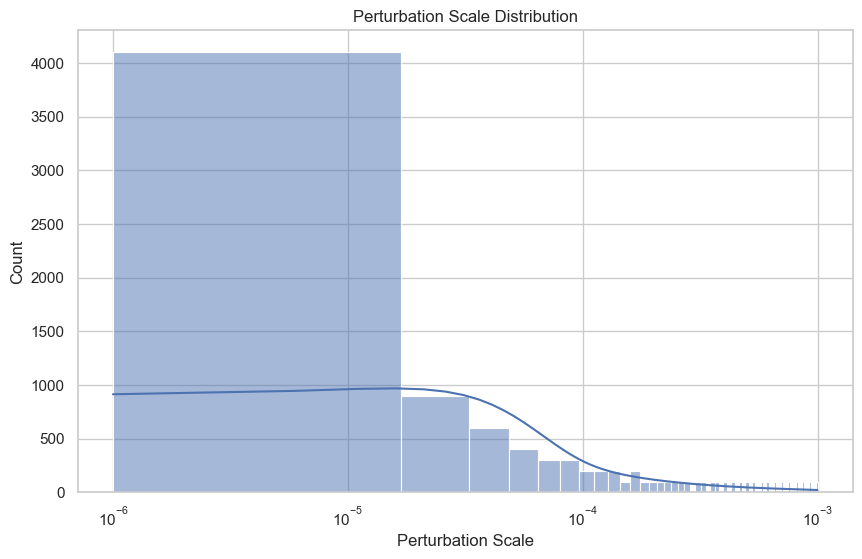

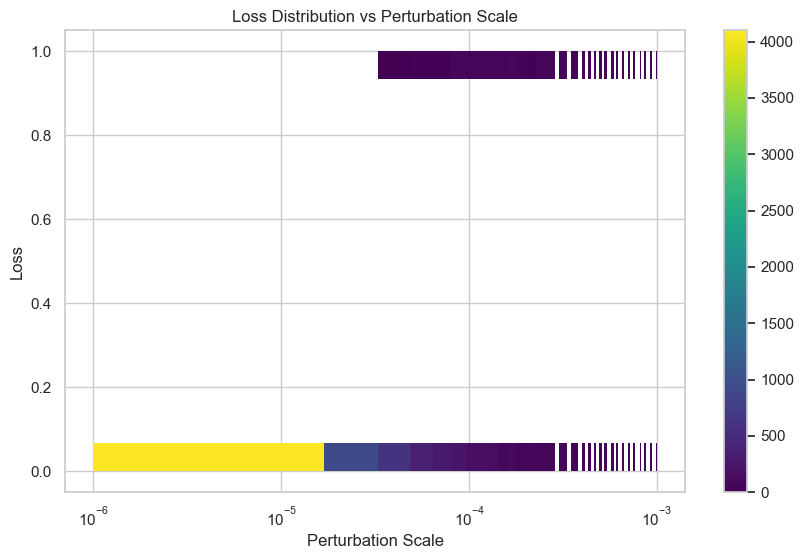

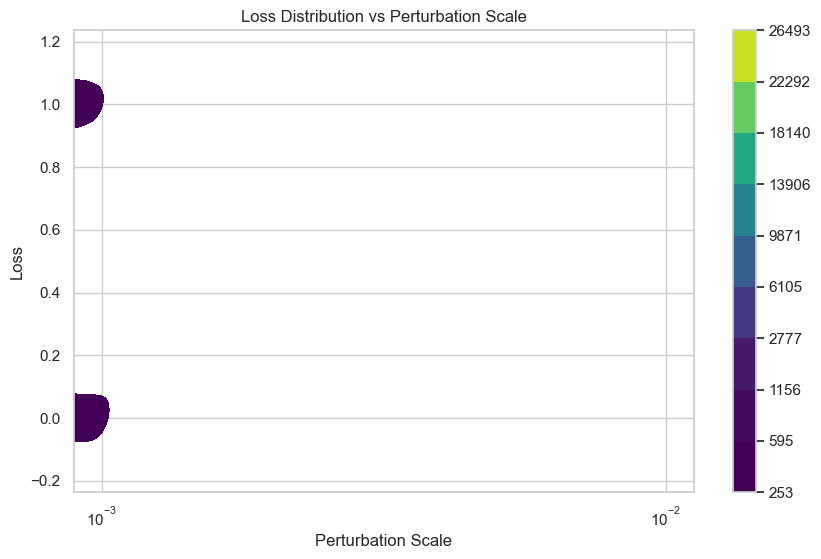

In [72]:
# plot the distribution results
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(losses_clean,kde=True)
plt.xlabel('Loss')
plt.title('Loss Distribution')
plt.xscale('log')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(perturbation_labels, kde=True)
plt.xlabel('Perturbation Scale')
plt.title('Perturbation Scale Distribution')
plt.xscale('log')
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.histplot(y = losses_clean, x = perturbation_labels, cmap='viridis', fill=True)
plt.colorbar(ax.collections[0], ax=ax)
plt.ylabel('Loss')
plt.xlabel('Perturbation Scale')
plt.xscale('log')
plt.title('Loss Distribution vs Perturbation Scale')
plt.show()


plt.figure(figsize=(10, 6))
ax = sns.kdeplot(y = losses_clean, x = perturbation_labels, cmap='viridis', fill=True)
plt.colorbar(ax.collections[0], ax=ax)
plt.ylabel('Loss')
plt.xlabel('Perturbation Scale')
plt.title('Loss Distribution vs Perturbation Scale')
plt.xscale('log')
plt.show()





/home/fifi/projects/homotopi/CV_project_24_25_HomotopyContinuation/src/HomoTopiContinuation/Plotter/Plotter.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax.legend()
/home/fifi/miniconda3/envs/homotopi/lib/python3.12/site-packages/matplotlib/contour.py:1364: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/home/fifi/miniconda3/envs/homotopi/lib/python3.12/site-packages/matplotlib/contour.py:1365: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/home/fifi/miniconda3/envs/homotopi/lib/python3.12/site-packages/numpy/ma/core.py:2892: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


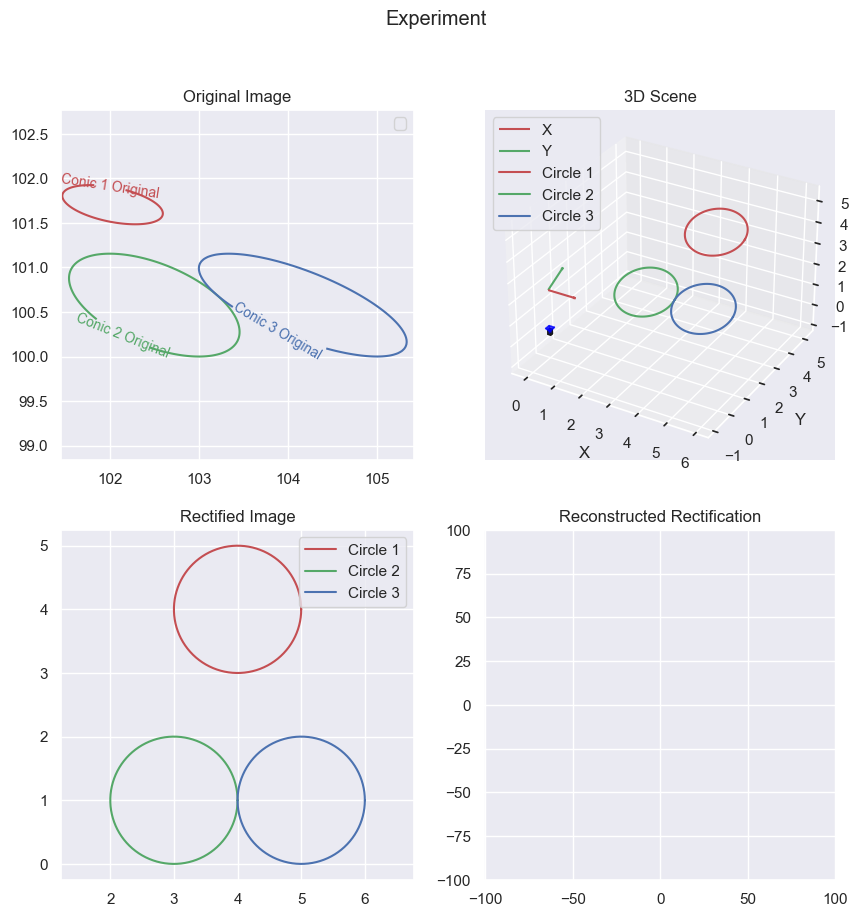

In [73]:


# Plot the results
plotter = Plotter(2, 2, title="Experiment")

plotter.plotExperiment(sceneDescription, img,
                        warpedConics)

plotter.show()